## 测试模型
样本信息：https://www.10xgenomics.com/datasets/human-kidney-preview-data-xenium-human-multi-tissue-and-cancer-panel-1-standard
选择乳头状肾细胞癌组织进行验证

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import h5py
from sklearn.metrics import confusion_matrix
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision import transforms
from PIL import Image
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
def load_patches_from_hdf5(h5_path):
    with h5py.File(h5_path, "r") as f:
        images = f["images"][:]        # shape: (N, H, W)
        labels = f["labels"][:]        # shape: (N,)
        barcodes = f["barcodes"][:].astype(str)  # shape: (N,)
    
    print(f"读取完成: {len(images)} 个样本")
    return images, labels, barcodes

In [36]:
h5_path = "./result/dapi_patches_20um_vali_55848.h5"
vali_patches, vali_labels, vali_barcodes = load_patches_from_hdf5(h5_path)

读取完成: 55848 个样本


In [40]:
# 平衡数据
def balance_data(patches, labels, barcodes):
    idx_pos = np.where(labels == 1)[0]
    idx_neg = np.where(labels == 0)[0]

    # 随机下采样负类到正类数量
    np.random.seed(42)
    idx_neg_sampled = np.random.choice(idx_neg, size=len(idx_pos), replace=False)

    idx_balanced = np.concatenate([idx_pos, idx_neg_sampled])
    np.random.shuffle(idx_balanced)

    return patches[idx_balanced], labels[idx_balanced], barcodes[idx_balanced]

# Dataset类（支持transform + resize）
class PatchDatasetWithTransform(Dataset):
    def __init__(self, patches, labels, barcodes, transform=None):
        self.patches = patches
        self.labels = labels
        self.barcodes = barcodes
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.patches[idx]  # numpy array
        label = self.labels[idx]
        barcode = self.barcodes[idx]

        # 转为 PIL.Image 并 apply transform
        image = Image.fromarray((image * 255).astype(np.uint8))  # 若为归一化图像（0~1）
        if self.transform:
            image = self.transform(image)

        return image, label, barcode

In [41]:
transform = transforms.Compose([
    transforms.Resize((92, 92)),   # 改为模型所需输入尺寸
    transforms.ToTensor()
])

# 进行负类下采样
balanced_patches, balanced_labels, balanced_barcode = balance_data(vali_patches, vali_labels, vali_barcodes)

# 创建 Dataset 和 DataLoader
test_dataset = PatchDatasetWithTransform(balanced_patches, balanced_labels, balanced_barcode, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [43]:
img, _, _ = test_dataset[0]
print("Image shape:", img.shape)  # 应该是 [1, H, W]

Image shape: torch.Size([1, 92, 92])


In [44]:
class SimpleCNN(nn.Module):
    def __init__(self, input_shape=(1, 92, 92)):  # 改为你的图像尺寸
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)

        # 动态获取flatten维度
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            x = self.pool1(F.relu(self.conv1(dummy)))
            x = self.pool2(F.relu(self.conv2(x)))
            flatten_dim = x.view(1, -1).shape[1]

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(flatten_dim, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
model.load_state_dict(torch.load("./models/best_model_epoch_3_20250828_110142.pt"))
model.eval()

# 预测
all_preds = []
all_labels = []
all_barcodes = []

with torch.no_grad():
    for images, labels, barcodes in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())
        all_barcodes.extend(barcodes)  # 直接是字符串 list

Confusion Matrix (in %):
[[25.67 74.33]
 [11.74 88.26]]


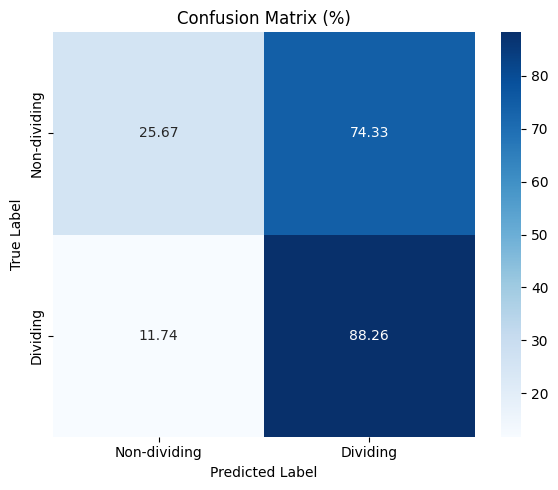

In [46]:
# 计算混淆矩阵（行是True Label，列是Predicted Label）
cm = confusion_matrix(all_labels, all_preds)
cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100

print("Confusion Matrix (in %):")
print(np.round(cm_percent, 2))

# 可视化
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=["Non-dividing", "Dividing"],
            yticklabels=["Non-dividing", "Dividing"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (%)")
plt.tight_layout()
plt.show()

In [47]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.preprocessing import label_binarize
import numpy as np

# 转换为numpy数组
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

# === 基本指标 ===
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

Accuracy:  0.5696
Precision: 0.5428
Recall:    0.8826
F1-score:  0.6722


In [49]:
from sklearn.metrics import roc_auc_score

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels, _ in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)  # logits
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # 只取 positive 类
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# 保证长度一致
print(len(all_labels), len(all_probs), len(all_preds))

# 计算 AUC
auc = roc_auc_score(all_labels, all_probs)
print(f"AUC: {auc:.4f}")

1192 1192 1192
AUC: 0.6309


In [ ]:
import pandas as pd
df_pred = pd.DataFrame({
    'Barcode': all_barcodes,
    'TrueLabel': all_labels,
    'PredLabel': all_preds
})
df_pred.head()


,Barcode,TrueLabel,PredLabel
0,edghmkbj-1,1,0
1,ofeodmln-1,1,1
2,fohankib-1,1,1
3,echiaaml-1,0,1
4,eagkpefk-1,0,0
